# Array Model Validation

**Date:** Jan 11th, 2025

**Author:** Jonah Lee

In this notebook, we compare (retroactively) predicted vs actual power for FSGP 2024 using our simplistic Hardware Array Model.

We use historical irradiance data provided by open-meteo as the ground truth for irradiance values, and telemetry current and voltage data as a ground truth for received electrical power. Note that both of these reference points have some inaccuracy: historical irradiance data is imperfect and not perfectly localized, and our array current sensors are known to somewhat inaccurate (though I do not know exactly in what way this is the case).

## 1. Imports & Setup

In [1]:
import enum
import pytz
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import openmeteo_requests
from data_tools import DBClient, FSGPDayLaps
from array_power import get_array_power, ArraySource

class IrradianceData(enum.Enum):
    """
    List of some relevant fields to be queried from open-meteo.

    See https://open-meteo.com/en/docs/historical-weather-api for other possible values to query.
    """
    GHI = "shortwave_radiation_instant"  # equal to DIR + DHI
    DIR = "direct_radiation_instant"  # in theory, equal to DNI*cos(solar_zenith), non-diffuse portion of GHI
    DNI = "direct_normal_irradiance_instant"
    DHI = "diffuse_radiation_instant"

# Establish a connection to InfluxDB
query_client = DBClient()

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


## 2. Calculate & Plot Actual Power

In [ ]:
# Array power in Watts, given by tel. current * voltage
actual_power = {
    "DAY_1": {
        "STRING_1": None,
        "STRING_2": None,
        "COMBINED": None,
    },
    "DAY_3": {
        "STRING_1": None,
        "STRING_2": None,
        "COMBINED": None,
    }
}

for day in (1, 3):
    race_day = FSGPDayLaps(day)
    start = race_day.get_start_utc(1)
    last_lap = race_day.get_lap_count()
    stop = race_day.get_finish_utc(last_lap)

    actual_power[f"DAY_{day}"]["STRING_1"] = get_array_power(start, stop, ArraySource.STRING_1, query_client)
    actual_power[f"DAY_{day}"]["STRING_2"] = get_array_power(start, stop, ArraySource.STRING_2, query_client)
    actual_power[f"DAY_{day}"]["COMBINED"] = get_array_power(start, stop, client=query_client)

    plt.plot(actual_power[f"DAY_{day}"]["STRING_1"], label="String 1")
    plt.plot(actual_power[f"DAY_{day}"]["STRING_2"], label="String 2")
    plt.plot(actual_power[f"DAY_{day}"]["COMBINED"], label="Combined")
    plt.title(f"Day {day} Race Array Power")
    plt.xlabel(f"Time Since Start ({start}), (s * 0.1)")
    plt.ylabel("Power (W)")
    plt.grid(True)
    plt.legend(loc="best")
    plt.show()

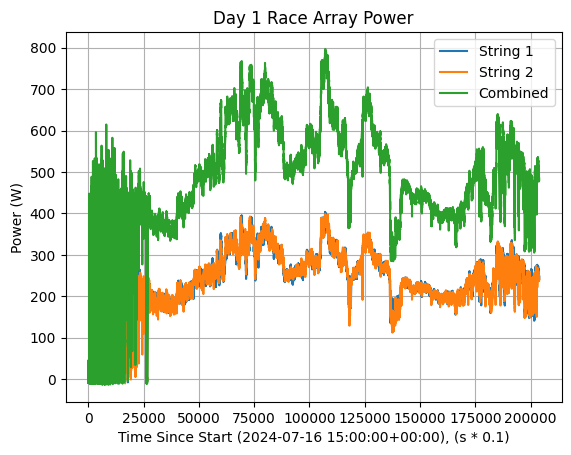

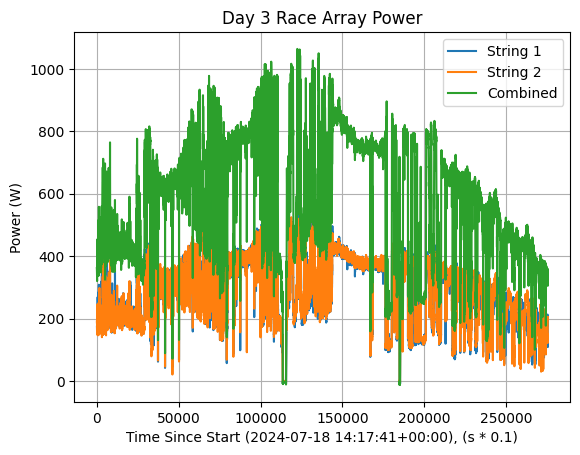

,DAY_1,DAY_3
STRING_1,"[-3.9965446619683007, -3.759302110221018, -3.5...","[173.80669452802977, 173.00989780121543, 172.2..."
STRING_2,"[-0.4415244709916699, 0.5296255336706873, 1.50...","[187.7178356264194, 188.2425387869018, 188.767..."
COMBINED,"[-4.438069132959971, -3.2296825059726766, -2.0...","[361.52453015444917, 361.25243757526897, 360.9..."


In [4]:
actual_power_df = pd.DataFrame(data=actual_power)
actual_power_df

In [7]:
np.save('array_actual_power', actual_power)

## 3. Calculate & Plot Predicted Power

In [12]:
# declare parameters for open-meteo query
# open-meteo provides historical data in sets of days, each with 24 hourly data points
# we need at least 2024-07-16T10:00:00 to 2024-07-18T17:00:00 America/Chicago time
QUERY_FIRST_DAY = "2024-07-16"  # midnight UTC -> 19:00 previous day America/Chicago time
QUERY_LAST_DAY = "2024-07-18"  # will get data until end of 18th UTC --> 19:00 America/Chicago time, i.e. 7pm
query_start: datetime = datetime.strptime(QUERY_FIRST_DAY, "%Y-%m-%d").replace(tzinfo=pytz.UTC)
query_stop: datetime = (datetime.strptime(QUERY_LAST_DAY, "%Y-%m-%d").replace(tzinfo=pytz.UTC)
                       + timedelta(hours=24))
NCM_MOTORSPORTS_LAT = 37.0006332
NCM_MOTORSPORTS_LONG = -86.3709907
TIMEZONE = "GMT"  # same as UTC
# Set up the Open-Meteo API client with cache and retry on error
# cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
# retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client()
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": NCM_MOTORSPORTS_LAT,
    "longitude": NCM_MOTORSPORTS_LONG,
    "start_date": QUERY_FIRST_DAY,
    "end_date": QUERY_LAST_DAY,
    "hourly": [IrradianceData.GHI.value],
    "timezone": TIMEZONE,
}
responses = openmeteo.weather_api(url, params=params)
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]

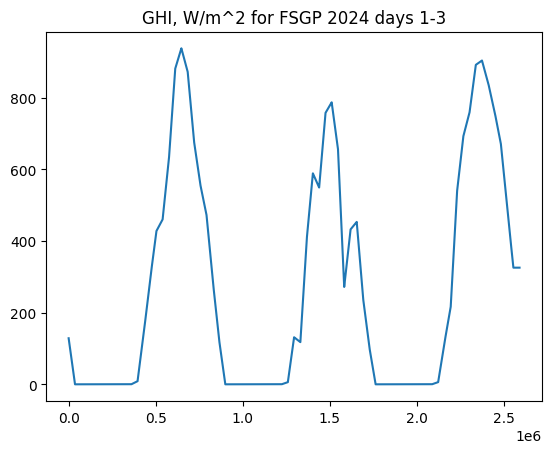

In [20]:
ghi = response.Hourly().Variables(0).ValuesAsNumpy()   
ghi_start = datetime.fromtimestamp(response.Hourly().Time()).replace(tzinfo=pytz.timezone('Etc/GMT+7'))
ghi_end = datetime.fromtimestamp(response.Hourly().TimeEnd()).replace(tzinfo=pytz.timezone('Etc/GMT+7'))

ghi_interpolated = np.interp(
    np.linspace(0, 72, int(72 * 3600 / 0.1)),
    range(72),
    ghi
)

plt.plot(ghi_interpolated)
plt.title('GHI, W/m^2 for FSGP 2024 days 1-3')
plt.show()

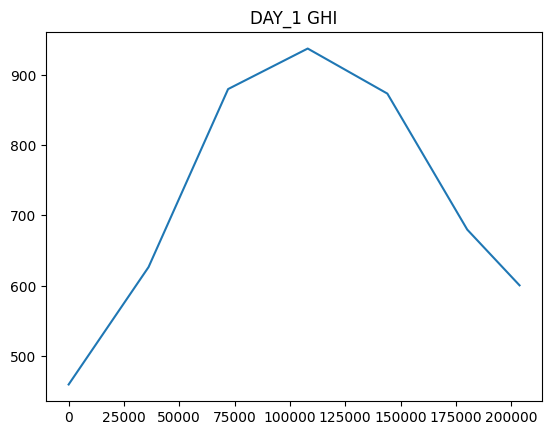

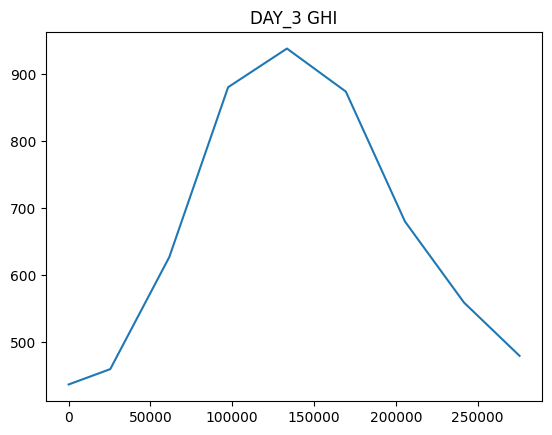

In [27]:
ghi = {}
for day in [1, 3]:
    race_day = FSGPDayLaps(day)
    last_lap = race_day.get_lap_count()

    pow_start = race_day.get_start_utc(1)
    pow_stop = race_day.get_finish_utc(last_lap)

    start_delay = pow_start - ghi_start

    combined_pow = actual_power_df[f"DAY_{day}"]["COMBINED"]
    ghi[f'DAY_{day}'] = ghi_interpolated[start_delay.seconds*10:start_delay.seconds*10 + len(combined_pow)]

plt.plot(ghi['DAY_1'])
plt.title('DAY_1 GHI')
plt.show()

plt.plot(ghi['DAY_3'])
plt.title('DAY_3 GHI')
plt.show()

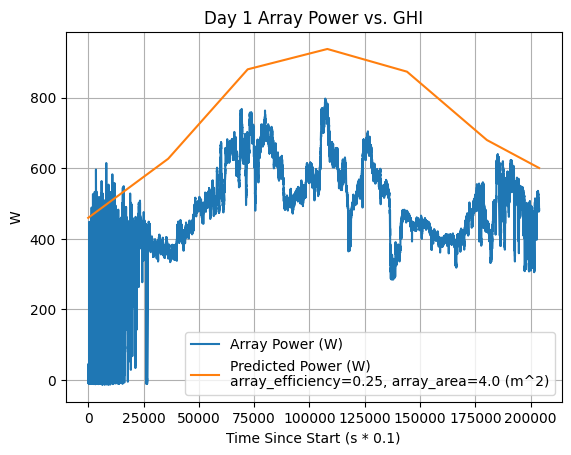

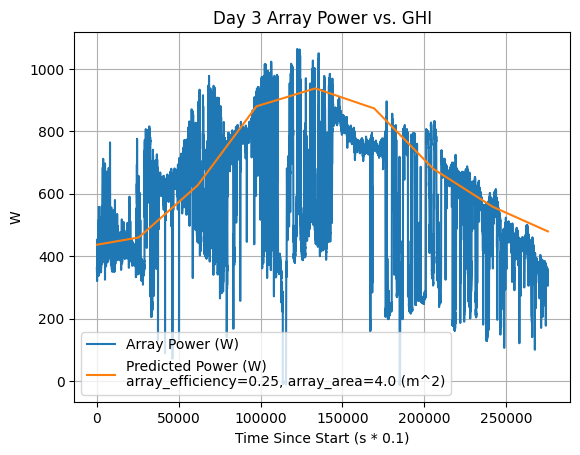

In [31]:
array_efficiency = 0.25  # dimensionless
array_area = 4.00  # m^2

predicted_pow = {
    "DAY_1": ghi[f'DAY_1'] * array_area * array_efficiency,
    "DAY_3": ghi[f'DAY_3'] * array_area * array_efficiency,
}

for day in [1, 3]:
    plt.plot(actual_power_df[f"DAY_{day}"]["COMBINED"], label="Array Power (W)")
    plt.plot(predicted_pow[f'DAY_{day}'], label=f"Predicted Power (W)\n{array_efficiency=}, {array_area=} (m^2)")
    plt.title(f"Day {day} Array Power vs. GHI")
    plt.xlabel("Time Since Start (s * 0.1)")
    plt.ylabel("W")
    plt.grid(True)
    plt.legend(loc="best")
    plt.show()

In [39]:
# compute cumulative error (magnitude)

data_frequency = 10  # watts per second

for day in [1, 3]:
    actual_kj = np.sum(actual_power_df[f"DAY_{day}"]["COMBINED"]) / data_frequency / 1000
    predicted_kj = np.sum(predicted_pow[f"DAY_{day}"]) / data_frequency / 1000
    print(f'Day {day} Actual kHJ: {actual_kj:.1f} kJ')
    print(f'Day {day} Predicted Energy: {predicted_kj:.1f} kJ')
    print(f'Day {day} Percent error: {np.abs(actual_kj / predicted_kj)*100:.3f}%')

Day 1 Actual kHJ: 9794.1 kJ
Day 1 Predicted Energy: 15516.5 kJ
Day 1 Percent error: 63.121%
Day 3 Actual kHJ: 15771.1 kJ
Day 3 Predicted Energy: 19140.8 kJ
Day 3 Percent error: 82.395%
